In [1]:
# basic operations
import os
import re

import pickle

# data analysis/management/manipulation
import numpy as np
import pandas as pd
# import sklearn

# text analysis
import emoji
import spacy
import en_core_web_lg
import gensim
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

# data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## load data
path = '/Users/nicole/Documents/ARP/code/FCAdata'

files = os.listdir(path)

In [3]:
to_concat = [] 

for file in files:
    if file.endswith('_1.csv'):
        print(file)

        #read file
        data = pd.read_csv(f'/Users/nicole/Documents/ARP/code/FCAdata/{str(file)}', lineterminator='\n')

        #select columns 
        data = data[['date', 'month_year', 'tweet', 'brand']]

        to_concat.append(data)

df = pd.concat(to_concat, ignore_index=True)

seat_1.csv
mini_1.csv
smart_1.csv
hondae_1.csv
ev_1.csv
renault_1.csv
fiat_1.csv


In [4]:
df.head()

,date,month_year,tweet,brand
0,2018-11-03,2018-11,Enjoy every minute of city living with the com...,seat
1,2018-11-03,2018-11,Enjoy every minute of city living with the com...,seat
2,2018-11-26,2018-11,Recent move: We took this #SeatMii to a film s...,seat
3,2019-01-17,2019-01,What a great start to a Thursday morning! Cong...,seat
4,2019-01-29,2019-01,Someone else had been lucky in an @AutoExpress...,seat


In [5]:
punctuation = '!”$%&\’()*+,-./:;<=>?[\\]^_`{|}~•@'

def give_emoji_free_text(tweet): 
    tweet = emoji.get_emoji_regexp().sub(r'', tweet)
    return tweet

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

# def remove_hashtags(tweet):
#     """Takes a string and removes any hash tags"""
#     tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
#     return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet



In [6]:
def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = give_emoji_free_text(tweet)
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    # tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = tweet.strip() # final strip
    return tweet


def clean_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['clean_tweet'] = df['tweet'].apply(basic_clean)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [7]:
df= clean_tweets(df)

Complete. Number of Tweets that have been cleaned and tokenized : 131562


In [8]:
# drop duplicates after cleaning
df.drop_duplicates(inplace=True, subset="clean_tweet")

In [9]:
# count the numbers of empty clean_tweet
sum(df['clean_tweet'] == '')

0

In [13]:
df1 = df.groupby(['brand', 'month_year'], as_index = False).agg({'clean_tweet':''.join})

In [17]:
nlp = en_core_web_lg.load()

In [18]:
# # list of abstract
DOCS = [i.strip().lower() for i in df1.clean_tweet]

# # # hyphen to underscores
DOCS = [re.sub(r'\b-\b', '_', text) for text in DOCS]

# # # transform Unicode whitespace characters to whitespace
DOCS = [re.sub(r'[\s]+', ' ', text) for text in DOCS]

In [34]:
stopwords = ['electricvehicle', 'electriccar', 'evs', 'car','tesla', 'bmw', 'vw', 'electric', 'honda', 'car', 'vehicle', 'hondae', 'toyota', 'gm'
'zoe', 'renault', 'renaultzoe', 'cars', 'ev', 'mini', 'minielectric', 'cooper', 'cooper_se', 'tsla', 'nio', 'amp', 'smart', 'eq', 'fortwo',
'smarteqfortwo','forfour', 'seat', 'fiat', '500e', 'fiat500', 'fiat500e','drive','cars', 'driving', 'drives', 'electriccars', 'electricvehicles']

 
for stopword in stopwords:
    nlp.vocab[stopword].is_stop = True

In [35]:
nlp.vocab['electriccars'].is_stop

True

In [36]:
# Filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if (token.is_stop == False)
                  and (token.is_punct == False)
                  and (token.like_num == False)] 
    DOCS_TOKENS.append(TMP_TOKENS)

In [37]:
# Check length of docs
length = []
for doc in DOCS:
    length.append(len(doc))

print(np.mean(length))
print(np.std(length))
print(max(length))
print(min(length))

48475.04643962848
54692.93979612666
279430
26


In [38]:
# Get rid of common terms
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# Find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=15000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=15000,
                  common_terms=COMMON_TERMS)

DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# Check nlp pipeline
print('original:', DOCS[0],
      'Tokenized description:', DOCS_TOKENS[0],
      'Tri-grammed tokenised description:', DOCS_PHRASED[0], sep='\n')

original:
360 degree tesla motors showroom experience – image #evs #electriccarsthe past is the future #electriccars#startupxcel mate #rimac stanford lecture 2016 #electriccars #conceptone #autonomousvehicles #croatia #startup#electriccars #tesla – safety of electric cars in question as tesla model s burns in norway while charging… #autosif we wanted #electriccars more than #selfdriving cars then there would be less #airpollutiotest drive these small cap automaker stocks spar sts etfm #automakers #electricvehicles #evselon musk can t stop… #uncategorized #apple #applecar #electriccars #elonmusk #topnewsnew addition to the fleet at #electriccarsthere s way more to faraday future than its crazy concept car #transportation #electriccars#vpa much more faster than #tesla by #electriccars vis saab the one to watch for evs #saab #evs #electriccarslong amp fast can #chevy #chevybolt turn tide for #electricvehicles via #naias #detroit #autoshowif you haven't considered #electricvehicles for you

In [39]:
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

In [40]:
# Change the path with your own
MALLET_PATH = '/Users/nicole/Desktop/CASS/term3/NLP/mallet-2.0.8/bin/mallet'

# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
# Collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 15, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=DICT,
                                                  corpus=CORPUS,
                                                  texts=DOCS_PHRASED,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

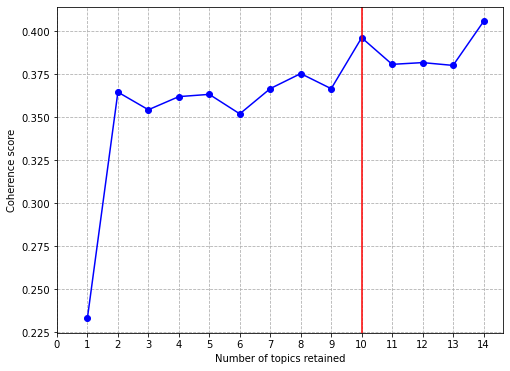

In [42]:
import matplotlib.pyplot as plt

# Plot collected coherence scores data
# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(8, 6))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(0,15,1))

# reference line
AX.axvline(x=10, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')

plt.show()

In [43]:
N_TOPICS = 14
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)

LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=10)



[(0,
  '0.016*"automotive" + 0.012*"auto" + 0.009*"read" + 0.009*"solar" + 0.009*"peugeot" + 0.009*"emobility" + 0.008*"mobility" + 0.008*"charge" + 0.008*"citroen" + 0.008*"renewable"'),
 (1,
  '0.170*"zoe" + 0.019*"£" + 0.017*"battery" + 0.013*"good" + 0.011*"charge" + 0.010*"nissan" + 0.010*"leaf" + 0.009*"sell" + 0.009*"range" + 0.009*"km"'),
 (2,
  '0.014*"se" + 0.009*"portable" + 0.008*"air" + 0.007*"china" + 0.006*"toy" + 0.006*"pump" + 0.006*"sell" + 0.006*"build" + 0.006*"safety" + 0.006*"brand"'),
 (3,
  '0.016*"hybrid" + 0.010*"production" + 0.009*"civic" + 0.009*"bike" + 0.009*"motor" + 0.008*"clarity" + 0.008*"start" + 0.008*"motorcycle" + 0.008*"uk" + 0.008*"brexit"'),
 (4,
  '0.018*"future" + 0.011*"technology" + 0.010*"news" + 0.010*"world" + 0.009*"power" + 0.009*"tech" + 0.009*"emission" + 0.008*"big" + 0.008*"clean" + 0.007*"increase"'),
 (5,
  '0.015*"km" + 0.012*"city" + 0.010*"kwh" + 0.010*"edition" + 0.008*"plugin" + 0.008*"sonible" + 0.008*"mii" + 0.007*"co2" + 